# Transformação de Variáveis

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import boxcox, yeojohnson
from statsmodels.tsa.stattools import adfuller

## Carregando os dados

In [3]:
us_change = pd.read_csv('us_change.csv')

In [4]:
# Convert the 'Quarter' column to datetime format using quarter ending
def parse_quarter(quarter_str):
    year, quarter = quarter_str.split(' ')
    month = int(quarter[1]) * 3
    return pd.Timestamp(f'{year}-{month:02d}-01')

us_change['Quarter'] = us_change['Quarter'].apply(parse_quarter)
us_change['QuarterDummy'] = us_change['Quarter'].dt.quarter

## Observando os dados

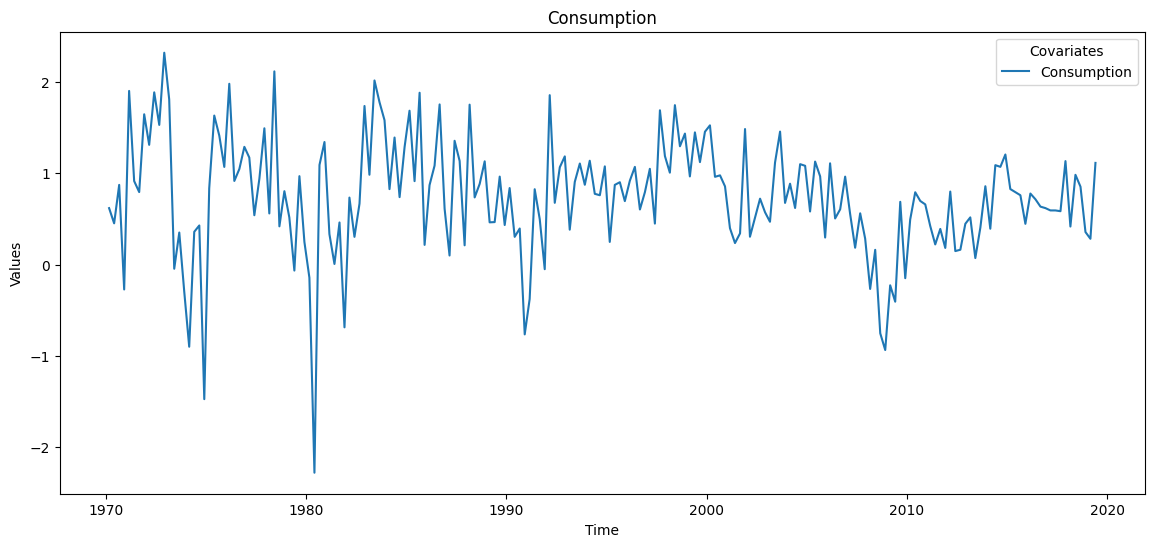

In [5]:
# Plot all covariates as time series

plt.figure(figsize=(14, 6))
sns.lineplot(data=us_change, x='Quarter', y='Consumption', label='Consumption')
plt.title('Consumption')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend(title='Covariates')
plt.show()

## Verificando Estacionariedade

Para verificar a estacionariedade da série iremos utilizar o teste de Dickey-Fuller aumentado (ADF). É um teste de raiz unitária que permite verificar a hipótese nula de que a série temporal possui raiz unitária, o que implica que a série não é estacionária. Se o valor-p do teste for menor que 0.05 (Um valor significativo), rejeitamos a hipótese nula e concluímos que a série é estacionária.

In [ ]:
result = adfuller(us_change['Consumption'])

print("Estatística do Teste ADF:", result[0])
print("Valor-p:", result[1])

if result[1] <= 0.05:
    print("A série é estacionária.")
else:
    print("A série não é estacionária.")

Estatística do Teste ADF: -4.610123144902199
Valor-p: 0.00012373240927130775
A série é estacionária.


Com isso concluímos que a série é estacionária.

## Estabilizando a Variância

Como podemos ver no primeiro gráfico, a tendência da série é decrescente no tempo. 

Abaixo podemos visualizar a variância de uma janela móvel 8 anos da série temporal. Podemos verificar que a variância de fato não é constante.

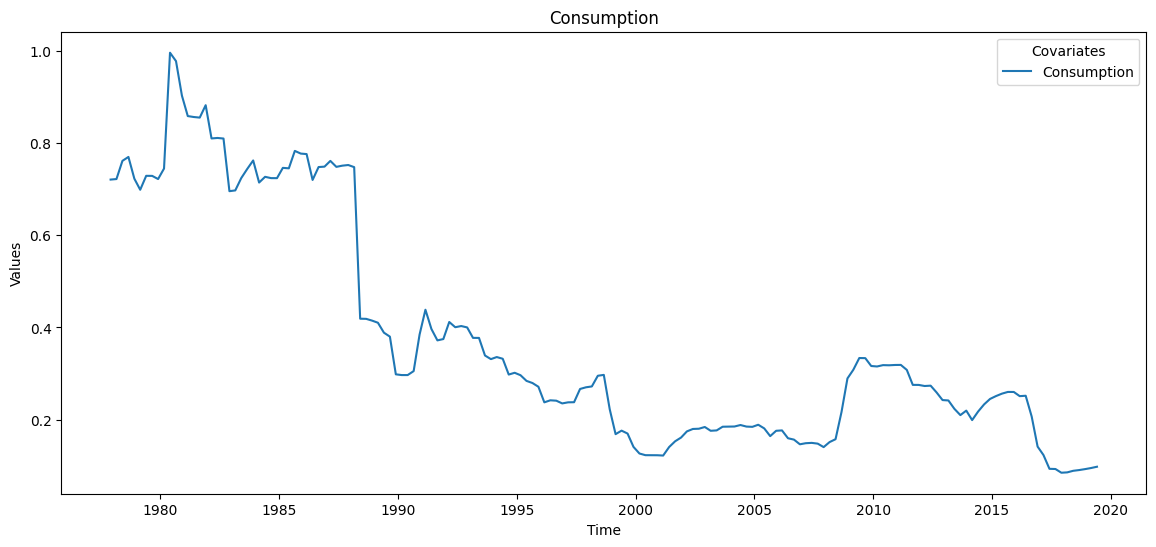

In [ ]:
# Variance 

plt.figure(figsize=(14, 6))
sns.lineplot(
    data=us_change.assign(
        Consumption=us_change['Consumption'].rolling(32).var()
    ),
    x='Quarter',
    y='Consumption',
    label='Consumption'
)
plt.title('Consumption')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend(title='Covariates')
plt.show()

Para contornar esse problema, podemos testar algumas transformações para estabilizar a variância da série. Uma das transformações mais comuns é a Box-Cox.

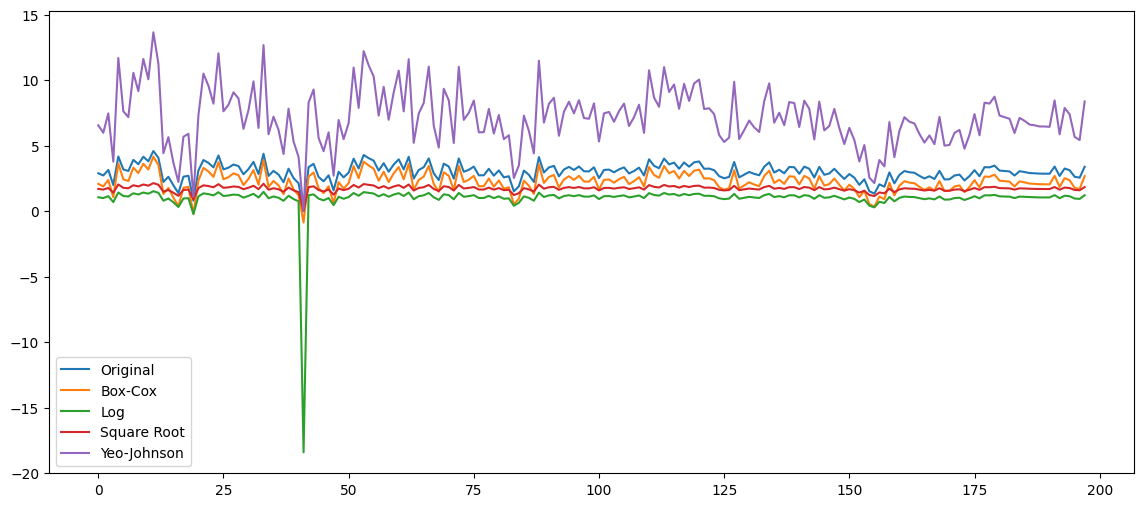

In [88]:
# Garantir valores positivos na série
lambda_2 = np.abs(us_change['Consumption'].min()) + 1e-8
series = us_change['Consumption'] + lambda_2

series_boxcox, lambda_ = boxcox(series)
series_boxcox = pd.Series(series_boxcox, index=us_change.index)

series_log = np.log(series)
series_log = pd.Series(series_log, index=us_change.index)

series_sqrt = np.sqrt(series)
series_sqrt = pd.Series(series_sqrt, index=us_change.index)

series_yeojohnson, lambda_yeojohnson = yeojohnson(series)
series_yeojohnson = pd.Series(series_yeojohnson, index=us_change.index)

fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(series, label='Original')
ax.plot(series_boxcox, label='Box-Cox')
ax.plot(series_log, label='Log')
ax.plot(series_sqrt, label='Square Root')
ax.plot(series_yeojohnson, label='Yeo-Johnson')

ax.legend()

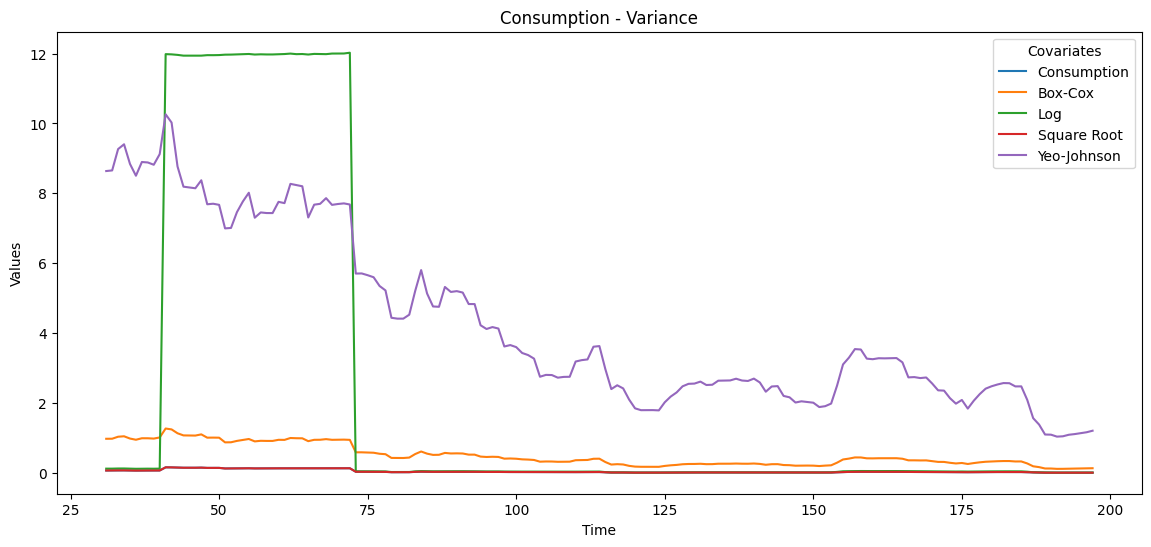

In [98]:
# Variance 

plt.figure(figsize=(14, 6))
sns.lineplot(
    data=us_change['Consumption'].rolling(32).var(),
    label='Consumption'
)
sns.lineplot(
    data=series_boxcox.rolling(32).var(),
    label='Box-Cox'
)
sns.lineplot(
    data=series_log.rolling(32).var(),
    label='Log'
)
sns.lineplot(
    data=series_sqrt.rolling(32).var(),
    label='Square Root'
)
sns.lineplot(
    data=series_yeojohnson.rolling(32).var(),
    label='Yeo-Johnson'
)
plt.title('Consumption - Variance')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend(title='Covariates')
plt.show()

A transformação de box-cox não conseguiu estabilizar a variância da série. De forma semelhante, as outras transformações não o fizeram, apenas alteraram o nível de variância da série.

## Conclusão

Como nossa série já é estacionária não precisamos aplicar transformações nesse sentido. Por outro lado, a variância da série não é constante, tentamos aplicar transformações para estabilizar a variância, mas nenhuma delas foi eficaz. Dessa forma, prosseguiremos com a modelagem da série temporal sem transformações.